In [29]:
!pip install openai pandas duckdb pydantic dotenv

# Building your Agent 

The agent is comprised of a router using OpenAI function calling, and a set of three tools: a database lookup tool, a data analysis tool, and a code generator to create graphs.

<img src="images/agent.png" width="500"/>


The agent can lookup information from a local file, perform analysis on that information, and graph results. The example local file is a log of transactions at a local store. The agent can help the store owners understand trends and anomalies in their sales data.

In [2]:
from openai import OpenAI
import pandas as pd
import json
import duckdb
from pydantic import BaseModel, Field
from IPython.display import Markdown

from helper import get_openai_api_key

## Initializing the OpenAI client

In [3]:
# initialize the OpenAI client
openai_api_key = get_openai_api_key()
client = OpenAI(api_key=openai_api_key)

MODEL = "gpt-4o-mini"

## Defining the tools

Let's start by creating the three tools the agent will be able to use.

In [4]:
# define the path to the transactional data
TRANSACTION_DATA_FILE_PATH = 'data/Store_Sales_Price_Elasticity_Promotions_Data.parquet'

This database lookup tool works using three steps. 

<img src="images/tool1.png" width="500"/>

1. First, it creates the SQL table from a local file, if not already done.
2. Second, it translates the original prompt into an sql query (using an LLM call).
3. Finally, it runs that query against the database.

In [5]:
# prompt template for step 2 of tool 1
SQL_GENERATION_PROMPT = """
Generate an SQL query based on a prompt. Do not reply with anything besides the SQL query.
The prompt is: {prompt}

The available columns are: {columns}
The table name is: {table_name}
"""

In [7]:
# code for step 2 of tool 1
def generate_sql_query(prompt: str, columns: list, table_name: str) -> str:
    """Generate an SQL query based on a prompt"""
    formatted_prompt = SQL_GENERATION_PROMPT.format(prompt=prompt, 
                                                    columns=columns, 
                                                    table_name=table_name)

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )

    return response.choices[0].message.content

In [8]:
# code for tool 1
def lookup_sales_data(prompt: str) -> str:
    """Implementation of sales data lookup from parquet file using SQL"""
    try:

        # define the table name
        table_name = "sales"
        
        # step 1: read the parquet file into a DuckDB table
        df = pd.read_parquet(TRANSACTION_DATA_FILE_PATH)
        duckdb.sql(f"CREATE TABLE IF NOT EXISTS {table_name} AS SELECT * FROM df")

        # step 2: generate the SQL code
        sql_query = generate_sql_query(prompt, df.columns, table_name)
        # clean the response to make sure it only includes the SQL code
        sql_query = sql_query.strip()
        sql_query = sql_query.replace("```sql", "").replace("```", "")
        
        # step 3: execute the SQL query
        result = duckdb.sql(sql_query).df()
        
        return result.to_string()
    except Exception as e:
        return f"Error accessing data: {str(e)}"

Great! Now let's test the first tool and make sure it worked correctly.

In [10]:
example_data = lookup_sales_data("Show me all the sales for store 1320 on November 1st, 2021")
print(example_data)

```sql
SELECT * 
FROM sales 
WHERE Store_Number = 1320 
AND Sold_Date = '2021-11-01';
```
    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo
0           1320    6173050               22875 2021-11-01         1          4.990000         0
1           1320    6174250               22875 2021-11-01         1          0.890000         0
2           1320    6176200               22975 2021-11-01         2         99.980003         0
3           1320    6176800               22800 2021-11-01         1         14.970000         0
4           1320    6177250               22975 2021-11-01         1          6.890000         0
5           1320    6177300               22800 2021-11-01         1          9.990000         0
6           1320    6177350               22800 2021-11-01         2         16.980000         0
7           1320    6177700               22875 2021-11-01         1          3.190000         0
8           1320    6178000          

### Tool 2: Data Analysis

The second tool can analyze the returned data and display conclusions to users.

<img src="images/tool2.png" width="300"/>

In [11]:
# Construct prompt based on analysis type and data subset
DATA_ANALYSIS_PROMPT = """
Analyze the following data: {data}
Your job is to answer the following question: {prompt}
"""

In [12]:
# code for tool 2
def analyze_sales_data(prompt: str, data: str) -> str:
    """Implementation of AI-powered sales data analysis"""
    formatted_prompt = DATA_ANALYSIS_PROMPT.format(data=data, prompt=prompt)

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )
    
    analysis = response.choices[0].message.content
    return analysis if analysis else "No analysis could be generated"

This tool is relatively simple, but let's still test it out to be sure things are working correctly.

In [13]:
print(analyze_sales_data(prompt="what trends do you see in this data", 
                         data=example_data))

To analyze the provided data, let's examine key trends and patterns based on the available columns: Store Number, SKU Code, Product Class Code, Sold Date, Quantity Sold, Total Sale Value, and On Promo. The data consists of sales records for a single store (Store_Number 1320) on a specific date (2021-11-01).

### Key Observations:

1. **Sales by Product Class**:
   - The data appears to include several product class codes (e.g., 22800, 22975, 24400) with varying sales quantities and values.
   - **Product Class 22975** and **24400** seem to have higher sale values indicating they may be higher-priced items compared to others like **22800** and **22875**, which show lower total sales values.

2. **Pricing Trends**:
   - There is a diversity in the total sale values for the items sold, ranging from approximately $0.89 to $99.98, with most items generally priced under $30.
   - The highest total sale value here is associated with a quantity of 2 units of **SKU_Coded 6176200 (Product Class 

### Tool 3: Data Visualization

The third tool generates python code to create the requested graphs from the returned data of the first tool. It consists of two steps:
    
<img src="images/tool3.png" width="500"/>
1. First, it creates the chart configuration: chart type, title, data, lables for x-axis and y-axis (using an LLM call).

2. Second, it generates the python code based on the chart configuration of the first step (using an LLM call).

In [14]:
# prompt template for step 1 of tool 3
CHART_CONFIGURATION_PROMPT = """
Generate a chart configuration based on this data: {data}
The goal is to show: {visualization_goal}
"""

# prompt template for step 1 of tool 3
CHART_CONFIGURATION_PROMPT = """
Generate a chart configuration based on this data: {data}
The goal is to show: {visualization_goal}
"""

In [15]:
# class defining the response format of step 1 of tool 3
class VisualizationConfig(BaseModel):
    chart_type: str = Field(..., description="Type of chart to generate")
    x_axis: str = Field(..., description="Name of the x-axis column")
    y_axis: str = Field(..., description="Name of the y-axis column")
    title: str = Field(..., description="Title of the chart")

In [16]:
# code for step 1 of tool 3
def extract_chart_config(data: str, visualization_goal: str) -> dict:
    """Generate chart visualization configuration
    
    Args:
        data: String containing the data to visualize
        visualization_goal: Description of what the visualization should show
        
    Returns:
        Dictionary containing line chart configuration
    """
    formatted_prompt = CHART_CONFIGURATION_PROMPT.format(data=data,
                                                         visualization_goal=visualization_goal)
    
    response = client.beta.chat.completions.parse(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
        response_format=VisualizationConfig,
    )
    
    try:
        # Extract axis and title info from response
        content = response.choices[0].message.content
        
        # Return structured chart config
        return {
            "chart_type": content.chart_type,
            "x_axis": content.x_axis,
            "y_axis": content.y_axis,
            "title": content.title,
            "data": data
        }
    except Exception:
        return {
            "chart_type": "line", 
            "x_axis": "date",
            "y_axis": "value",
            "title": visualization_goal,
            "data": data
        }

In [17]:
# prompt template for step 2 of tool 3
CREATE_CHART_PROMPT = """
Write python code to create a chart based on the following configuration.
Only return the code, no other text.
config: {config}
"""

In [18]:
# code for step 2 of tool 3
def create_chart(config: dict) -> str:
    """Create a chart based on the configuration"""
    formatted_prompt = CREATE_CHART_PROMPT.format(config=config)
    
    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )
    
    code = response.choices[0].message.content
    code = code.replace("```python", "").replace("```", "")
    code = code.strip()
    
    return code

In [19]:
# code for tool 3
def generate_visualization(data: str, visualization_goal: str) -> str:
    """Generate a visualization based on the data and goal"""
    config = extract_chart_config(data, visualization_goal)
    code = create_chart(config)
    return code

Great, now let's try the third tool out:

In [20]:
code = generate_visualization(example_data, 
                              "A bar chart of sales by product SKU. Put the product SKU on the x-axis and the sales on the y-axis.")
print(code)

import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Store_Number': [1320]*30,
    'SKU_Coded': [6173050, 6174250, 6176200, 6176800, 6177250, 6177300, 6177350, 6177700, 6178000, 6178250, 
                  6179250, 6179300, 6179400, 6179450, 6179500, 6179750, 6180550, 6182050, 6183750, 6184100, 
                  6188550, 6190050, 6190150, 6190200, 6190250, 6190350, 6190400, 6193750, 6195350, 6195800],
    'Product_Class_Code': [22875, 22875, 22975, 22800, 22975, 22800, 22800, 22875, 22875, 22800, 
                           24400, 22800, 24400, 24400, 24400, 22800, 22975, 22975, 22850, 22975, 
                           22950, 24425, 24425, 24425, 24425, 22950, 22950, 22875, 24375, 22850],
    'Sold_Date': ['2021-11-01']*30,
    'Qty_Sold': [1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 
                 1, 2, 2, 1, 1, 2, 1, 1, 3, 3, 
                 2, 5, 1, 1, 1, 1, 1, 1, 1, 3],
    'Total_Sale_Value': [4.99, 0.89, 99.98, 14.97, 6.89, 9.99, 16.98, 3.19, 6.38, 16.59, 
                

Matplotlib is building the font cache; this may take a moment.


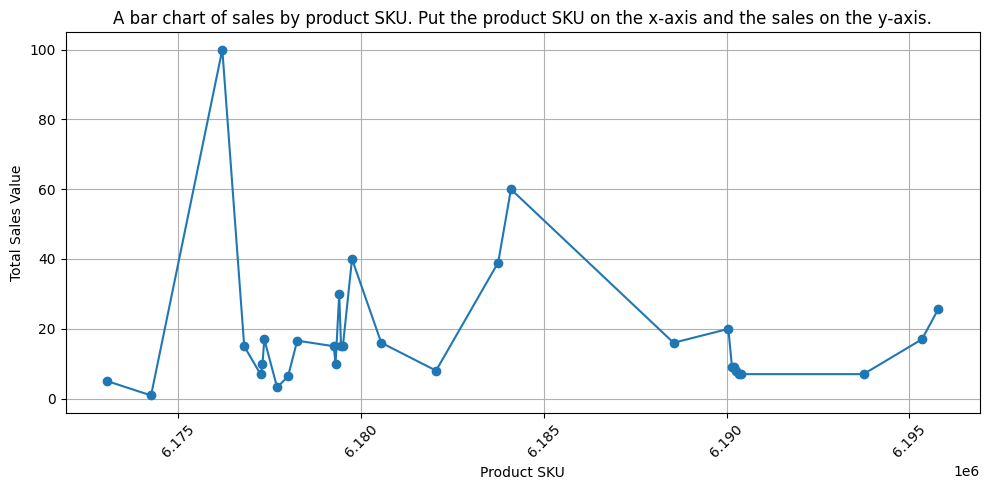

In [21]:
exec(code)

## Defining the Router

Now that all of the tools are defined, you can create the router. The router will take the original user input, and is responsible for calling any tools. After each tool call is completed, the agent will return to router to determine whether another tool should be called.

### Tool Schema

Let's define the tools in a way that can be understood by our OpenAI model. OpenAI understands a specific JSON format:

In [25]:
# Define tools/functions that can be called by the model
tools = [
    {
        "type": "function",
        "function": {
            "name": "lookup_sales_data",
            "description": "Look up data from Store Sales Price Elasticity Promotions dataset",
            "parameters": {
                "type": "object",
                "properties": {
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "analyze_sales_data", 
            "description": "Analyze sales data to extract insights",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["data", "prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "generate_visualization",
            "description": "Generate Python code to create data visualizations",
            "parameters": {
                "type": "object", 
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "visualization_goal": {"type": "string", "description": "The goal of the visualization."}
                },
                "required": ["data", "visualization_goal"]
            }
        }
    }
]

# Dictionary mapping function names to their implementations
tool_implementations = {
    "lookup_sales_data": lookup_sales_data,
    "analyze_sales_data": analyze_sales_data, 
    "generate_visualization": generate_visualization
}

### Router Logic

The router is composed of a main loop method, and a method to handle the tool calls that you get back from the model.

<img src="images/router.png" width="800"/>

The following two cells define the function `handle_tool_calls` and the variable `SYSTEM_PROMPT`, which will be used by the function `run_agent` defining the router logic.

In [23]:
# code for executing the tools returned in the model's response
def handle_tool_calls(tool_calls, messages):
    
    for tool_call in tool_calls:   
        function = tool_implementations[tool_call.function.name]
        function_args = json.loads(tool_call.function.arguments)
        result = function(**function_args)
        messages.append({"role": "tool", "content": result, "tool_call_id": tool_call.id})
        
    return messages

In [24]:
SYSTEM_PROMPT = """
You are a helpful assistant that can answer questions about the Store Sales Price Elasticity Promotions dataset.
"""

In [26]:
def run_agent(messages):
    print("Running agent with messages:", messages)

    if isinstance(messages, str):
        messages = [{"role": "user", "content": messages}]
        
    # Check and add system prompt if needed
    if not any(
            isinstance(message, dict) and message.get("role") == "system" for message in messages
        ):
            system_prompt = {"role": "system", "content": SYSTEM_PROMPT}
            messages.append(system_prompt)

    while True:
        print("Making router call to OpenAI")
        response = client.chat.completions.create(
            model=MODEL,
            messages=messages,
            tools=tools,
        )
        messages.append(response.choices[0].message)
        tool_calls = response.choices[0].message.tool_calls
        print("Received response with tool calls:", bool(tool_calls))

        # if the model decides to call function(s), call handle_tool_calls
        if tool_calls:
            print("Processing tool calls")
            messages = handle_tool_calls(tool_calls, messages)
        else:
            print("No tool calls, returning final response")
            return response.choices[0].message.content

In [27]:
result = run_agent('Show me the code for graph of sales by store in Nov 2021, and tell me what trends you see.')

Running agent with messages: Show me the code for graph of sales by store in Nov 2021, and tell me what trends you see.
Making router call to OpenAI
Received response with tool calls: True
Processing tool calls
```sql
SELECT Store_Number, SUM(Qty_Sold) AS Total_Qty_Sold, SUM(Total_Sale_Value) AS Total_Sale_Value
FROM sales
WHERE Sold_Date >= '2021-11-01' AND Sold_Date <= '2021-11-30'
GROUP BY Store_Number;
```
Making router call to OpenAI
Received response with tool calls: True
Processing tool calls
Making router call to OpenAI
Received response with tool calls: False
No tool calls, returning final response


In [28]:
print(result)
# you can also print a formatted version of the result
# Markdown(result)

Here's the code to generate a graph of sales by store for November 2021:

```python
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

data = """Store_Number  Total_Qty_Sold  Total_Sale_Value
0            880          1525.0      17753.769956
1           4730           819.0      10571.779962
2           1540          1801.0      21207.689942
3           1210          1821.0      21021.669984
4           1650          1770.0      23186.909958
5            330          1105.0      12569.599911
6           4840          1612.0      19127.169971
7           1320          1701.0      19553.789981
8           3190          1003.0      11934.999961
9           1760          1207.0      14598.209948
10          4180           913.0      10213.819920
11          4070           932.0       9161.409921
12          3080          1454.0      18044.450005
13          1980           893.0       9084.959929
14          1100          1712.0      19298.679917
15          2750 